In [2]:
# ! pip install SPARQLWrapper
# TODO: Remember to mention in documentation

  Using cached SPARQLWrapper-1.8.5-py3-none-any.whl (26 kB)
  Using cached rdflib-6.1.1-py3-none-any.whl (482 kB)
  Using cached isodate-0.6.1-py2.py3-none-any.whl (41 kB)


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from SPARQLWrapper import SPARQLWrapper, JSON

%matplotlib inline

In [2]:
# Reading the data from politics revisions
# Contains the revisions for all the selected items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/politics_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/politics.csv')

In [3]:
revisions.shape

(3915164, 12)

In [4]:
items.shape

(414463, 3)

Using SPARQL to retrieve the labels for all the items by using the corresponding qids

In [12]:
# Specifying the Wikidata SPARQL endpoint
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

In [45]:
# Query to access the label for the wikidata item
sparql.setQuery("""
    SELECT ?label 
    WHERE {
      wd:Q109321 rdfs:label ?label . 
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
      }
    LIMIT 1
""")

# Converting result to JSON format
sparql.setReturnFormat(JSON)
result = sparql.query().convert()
print(result)

{'head': {'vars': ['label']}, 'results': {'bindings': [{'label': {'xml:lang': 'af', 'type': 'literal', 'value': 'Albrecht Schläger'}}]}}


In [36]:
print(result["results"]["bindings"])
print(result["results"]["bindings"][0])
print(result["results"]["bindings"][0]["label"])

[{'label': {'xml:lang': 'af', 'type': 'literal', 'value': 'Albrecht Schläger'}}]
{'label': {'xml:lang': 'af', 'type': 'literal', 'value': 'Albrecht Schläger'}}
{'xml:lang': 'af', 'type': 'literal', 'value': 'Albrecht Schläger'}


In [37]:
print(result["results"]["bindings"][0]["label"]["value"])

Albrecht Schläger


In [109]:
def get_item_label(qid):
    try:        
        # Specifying the Wikidata SPARQL endpoint
        sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
        
        # Query to access the label for the wikidata item
        sparql.setQuery('PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ?label WHERE {wd:' + qid + ' rdfs:label ?label . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } } LIMIT 1')
        
        # Converting result to JSON format
        sparql.setReturnFormat(JSON)
        result = sparql.query().convert()
        
        # result is in the form of "bindings" which are a list of dictionaries
        # Accessing the value of the label 
        itemLabel = result["results"]["bindings"][0]["label"]["value"]
        
        return itemLabel
    except Exception as ex:
        print(ex)
        return('')

In [111]:
start = time.process_time()
print(get_item_label("Q22686"))
print(time.process_time() - start)

Donald Trump
0.046875


In [ ]:
# Retrieiving labels for the items dataframe first 
# This will make the process quicker as compared to doing it for all revisions
items['label'] = [get_item_label(qid) for qid in items['qid']]

HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
<urlopen error [WinError 10065] A socket operation was attempted to an unreachable host>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno

# Data Cleaning

What all needs to be done?

1. The edit type needs to be redone as multiple edge cases were discovered during thedata parsing and collection stage which were not known beforehand or from sampling 10000 revisions.

- Comment - check for type such as if it is a revert, undo or if it is a predefined edit action like wbsetlabel - add:

- If of type wbset...:..../.. break the string up at the first occurrence of the colon :

- Then look at whether it is part of the edge cases wbsetlabeldescriptionaliases, .. etc and if not then it must be of type wbsetlabel- add, then look at the text before and after the dash. 

- this can probably be done by defining a method which takes in the comment, analyses it with a series of if statements, uses regex to break up the text etc and then returns 1 value for edit type or two values in a tuple for edit type and edit entity which can then be added to the dataframe using [0] and [1]

2. Remove items and their respective revisions with editcount below a certain value - need to research, find a paper on edits and do it.

3. Idea: could also lable the edits based on contributors - research paper whih categorised contributors into registered, anonymous and bots (already have a list of bots - just need to verify the data) 

4. Remove items with edits only from bots.

5. Drop unecessary rows (pageid) userid might be needed to see if the contributors are the same or not - will not need if i can confirm that usernames are unique on wikidata

6. Last or possibly at a later stage - convert the timestamp to a datetime object

In [5]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [6]:
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # Converting the comment to lowercase
    # c = comment.decode("utf-8").lower()
    c = comment.lower()
    #print(c)
    editType = '' 
    
    if c == '':
        return editType
    
    if "|" in c:
        # Comments which have |
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            editType = 'undo'
            return editType
        elif 'restore' in cc:
            editType = 'restore'
            return editType
        elif 'wbsetclaimvalue' in cc:
            editType = 'set'
            return editType
        elif 'wbsetlabeldescriptionaliases' in cc:
            editType = 'set'
            return editType
        elif 'wbcreateredirect' in cc:
            editType = 'create'
            return editType
        elif 'merge' in cc:
            editType = 'merge'
            return editType
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                editType = 'create'
                return editType
            elif 'add' in ccc:
                editType = 'add'
                return editType
            elif 'set' in ccc:
                editType = 'set'
                return editType
            elif 'update' in ccc:
                editType = 'update'
                return editType
            elif 'remove' in ccc:
                editType = 'remove'
                return editType
    if 'revert' in c: 
        editType = 'revert'
        return editType  
    elif 'protect' in c:
        editType = 'protect'
        return editType  
    elif 'undid' in c:
        editType = 'undo'
        return editType      
    return editType
        

In [7]:
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [8]:
# rev.to_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/revisions_type.csv')

In [12]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [15]:
# converting a series to a dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')

In [16]:
print(ts)

           count
type            
add      2860493
create    622289
update    286812
remove     81037
set        40207
           17761
merge       3090
undo        1470
revert      1434
restore      547
protect       24


In [17]:
tss = ts.rename(index={'': 'no type'})

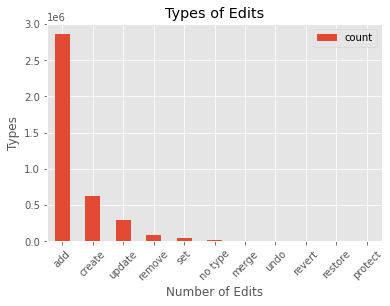

In [43]:
# ax = tss.plot.barh()
ax = tss.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

# ax.invert_yaxis()

plt.show()

According to the bar plot the proxy with the highest occurrence is add followed by create, update, remove, set and those with no types specified (those without any comments). 

This was expected behaviour as this infers that editors are adding a lot of information to wikidata over a period of time. As we are exploring controversies in wikidata, the remaining edits namely - reverts, undos, removes, merges, restores and protect will be more useful thus we will visualise those.

Proxies

The follwoing are those that we are interested in as they would give us more information controversial edits:

- remove
- restore
- revert
- merge
- undo 
- protected (these are in cases of vandalism - read docs and consider whether to include)

The remaining will give us general information about content being added or updated:

- create
- add
- set
- update

In [34]:
#  extracting only select proxies
controversial_proxies = tss.iloc[[3, 6, 7, 8, 9, 10]]
# tss.loc[['revert', 'merge', 'restore']]

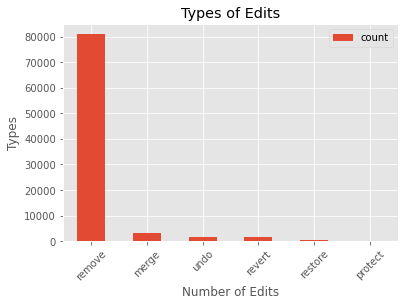

In [44]:
# ax = tss.plot.barh()
ax = controversial_proxies.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

# ax.invert_yaxis()

plt.show()

Edits with proxy type remove are still very high that is > 80,000 wheras all the remaning are less that 10,000. This shows the disparity between the different types of edits being made. Reverts, merges, undos, restores and protects form a very small portion of the data. 

In [15]:
rev.head()

,Unnamed: 0,qid,revisionid,timestamp,comment,userid,username,editscount,type
0,0,Q2123572,1920126.0,2016-10-10T16:02:04Z,b'/* wbcreateclaim-create:1| */ [[Property:P77...,1920126.0,b'NikkiBot',3,create
1,1,Q2123572,1920126.0,2016-10-10T16:02:05Z,b'/* wbsetreference-add:2| */ [[Property:P774]...,1920126.0,b'NikkiBot',3,add
2,2,Q2123572,1787420.0,2016-12-29T18:42:09Z,b'/* wbsetdescription-add:1|he */ \xd7\xa2\xd7...,1787420.0,b'Mikey641',3,add
3,3,Q2123580,110062.0,2016-10-12T14:37:53Z,b'/* wbcreateclaim-create:1| */ [[Property:P41...,110062.0,b'Thierry Caro',7,create
4,4,Q2123580,110062.0,2016-10-12T14:37:55Z,b'/* wbsetreference-add:2| */ [[Property:P41]]...,110062.0,b'Thierry Caro',7,add


In [46]:
rev.dtypes

Unnamed: 0      int64
qid            object
revisionid    float64
timestamp      object
comment        object
userid        float64
username       object
editscount      int64
type           object
dtype: object

In [47]:
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [48]:
bots.shape

(335, 1)

In [49]:
bots.dtypes

bot_name    object
dtype: object

In [50]:
rev.columns

Index(['Unnamed: 0', 'qid', 'revisionid', 'timestamp', 'comment', 'userid',
       'username', 'editscount', 'type'],
      dtype='object')

Labelling the Contributors into the following 3 types:

- Registered users: Editors with an account and user name.
- Anonymous Users: Editors without a user account but with an IP address.
- Bots

Assumptions:

- Empty contributors are ones who are using an ip address thus will be called anonymous users
- Contributors part of the bots list will be labelled as bots
- All remaining contributors with a username will be called Registered Users

Ref: When Humans and Machines Collaborate: Cross-lingual Label Editing in Wikidata


In [51]:
def get_user_type(user):
    
    u = user[1:].replace("'", "")
    
    userType = ''
    
    if u == "":
        userType = 'Anonymous'
        return userType
    elif u in bots.values:
        userType = 'Bot'
        return userType
    else: 
        userType = 'Registered'
        return userType
    return userType
    

In [52]:
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [53]:
# rev.to_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/revisions_user_type.csv')

In [54]:
rev['usertype'].value_counts()

Registered    3246374
Bot            649238
Anonymous       19552
Name: usertype, dtype: int64

In [55]:
rev['username']

0              b'NikkiBot'
1              b'NikkiBot'
2              b'Mikey641'
3          b'Thierry Caro'
4          b'Thierry Caro'
                ...       
3915159     b'Tagishsimon'
3915160     b'Tagishsimon'
3915161     b'Tagishsimon'
3915162     b'Tagishsimon'
3915163     b'Tagishsimon'
Name: username, Length: 3915164, dtype: object

As we are interested only in wikidata items that are highly edited within the given time span, items with an editcount <= 5 will be removed from the dataset.

In [56]:
# Removing items with editcount <=5
rev['editscount'] < 5

0           True
1           True
2           True
3          False
4          False
           ...  
3915159     True
3915160     True
3915161     True
3915162     True
3915163     True
Name: editscount, Length: 3915164, dtype: bool

In [57]:
to_remove = rev[rev['editscount'] <= 5].index

In [58]:
rev_highly_edited = rev.drop(to_remove)

In [59]:
# rev_highly_edited.to_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/revisions_highly_edited.csv')

In [60]:
rev_highly_edited.shape

(3297981, 10)

In [61]:
# (rev_highly_edited['qid'].value_counts()).to_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/revisions_highly_edited_qids.csv')

In [62]:
highly_edited_items = rev_highly_edited['qid'].value_counts()

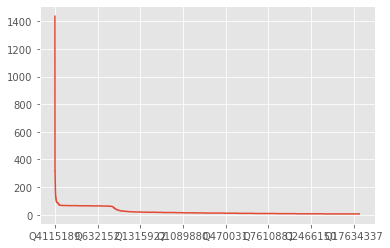

In [75]:
highly_edited_items.plot.line()

In [64]:
items = highly_edited_items.index.to_numpy()
editcounts = highly_edited_items.to_numpy()

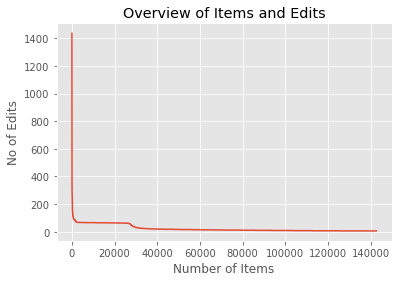

In [122]:
plt.plot(editcounts)

plt.title("Overview of Items and Edits")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

Above plot shos that there are very few items with edist > 150/200. Most of the items within the dataset of more that a 140,000 items have edits that are verly low. Therefore a large perecentage of the dataset contains items with edits > 150 or > 200.

What happens if we take a look at the highly edited items?

Should probably have some statistical calculation to do this.

In [78]:
highly_edited_items.describe()

count    142538.000000
mean         23.137556
std          25.184644
min           6.000000
25%           8.000000
50%          12.000000
75%          22.000000
max        1437.000000
Name: qid, dtype: float64

From the above description of the highly edited items within this dataframe after data cleaning (before removing edits with empty comments - need to do that) we can see that about 75% of the items (106904 items) have their edits = to or below 22 edits. 

So let us look at the top 40,000 items in this dataset.

In [84]:
# converting a series to a dataframe
top_40k = pd.DataFrame({'qid':highly_edited_items.index, 'editcount':highly_edited_items.values})

In [112]:
top_1k = top_40k.head(200)

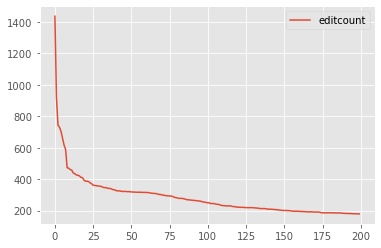

In [115]:
top_1k.plot.line()

Only very few items in the dataset with very large edit counts. This graph for only 20 items shows how many of them have edits above a certain value.
Scatter plot might be better as it will show which points are the densest and how many items have edit counts as high as 1400.

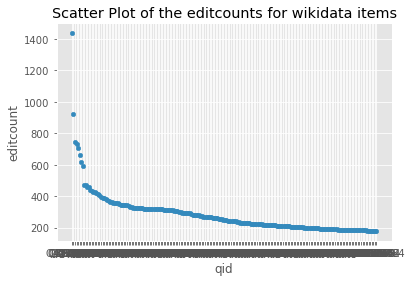

In [120]:
top_1k.plot.scatter(x='qid', y='editcount', title="Scatter Plot of the editcounts for wikidata items")

1 item in 1400 range, 1 in 900 range, few in 600-800 range.

Note that very few items are in the higher ranges. Only 1 item in 1400 and 900, few between 600-800 and the remaining below 500.

Can individually visualise the first few > 500 - can look at the no of reverts for each of them in one plot - look at the proxies - then look at the remainign items together - create a wordcloud, histogram.

In [123]:
highly_edited_items.index

Index(['Q4115189', 'Q3642765', 'Q3964154', 'Q4504204', 'Q534197', 'Q1085',
       'Q2627691', 'Q3955158', 'Q2627656', 'Q649',
       ...
       'Q6286291', 'Q15906584', 'Q1829243', 'Q5345397', 'Q468814', 'Q7527905',
       'Q555373', 'Q3293898', 'Q674869', 'Q27662828'],
      dtype='object', length=142538)